In [32]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import feedparser as fp
import prophet as pr

In [33]:
DATAPATH = './data'
STOCKSPATH = os.path.join(DATAPATH, 'stocks')
METADATA = os.path.join(DATAPATH, 'symbols_valid_meta.csv')

In [34]:
# Load the metadata
metadata = pd.read_csv(METADATA)

In [35]:
metadata.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [36]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB


In [37]:
metadata.shape

(8049, 12)

In [38]:
# Check for null values
metadata.isnull().sum()

Nasdaq Traded          0
Symbol                 0
Security Name          0
Listing Exchange       0
Market Category        0
ETF                    0
Round Lot Size         0
Test Issue             0
Financial Status    4666
CQS Symbol          3383
NASDAQ Symbol          0
NextShares             0
dtype: int64

Here, I can spot a coule of null values for the field 'Financial Status' and 'CQS Symbol'. Not sure what to do with them yet.

In [39]:
# Loading the stock data for a random company
stock_APPL = pd.read_csv(os.path.join(STOCKSPATH, 'AAPL.csv'))

In [40]:
stock_APPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [41]:
stock_APPL.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500
9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,240.910004,43956200


There seems to be 5884 files in the stock directory.
Is there a way to find out the agerage max and min dates for all stock companies?

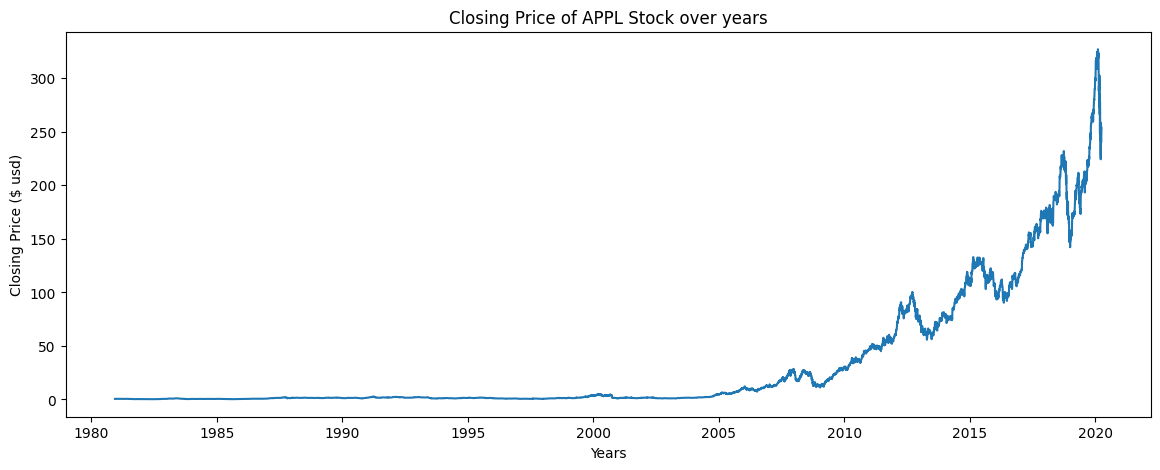

In [42]:
# Plot the closing price of the APPL stock over years
stock_APPL['Date'] = pd.to_datetime(stock_APPL['Date'])

plt.figure(figsize=(14, 5))
plt.plot(stock_APPL['Date'], stock_APPL['Close'])
plt.xlabel('Years')
plt.ylabel('Closing Price ($ usd)')
plt.title('Closing Price of APPL Stock over years')
plt.show()


In [43]:
# rss_url = 'https://www.ft.com/business-education?format=rss'
# feed = fp.parse(rss_url)

In [44]:
# # Print all feed entries
# for entry in feed.entries:
#     print(entry.title)

In [45]:
stock_APPL_new = stock_APPL[['Date', 'Close']]

# Selecting the max cap to be 30% more than the max value of the closing price
stock_APPL_new['cap'] = max(stock_APPL_new['Close']) * 1.3

# Renaming the columns as required by the prophet model
stock_APPL_new = stock_APPL_new.rename(columns={'Date': 'ds', 'Close': 'y'})

/var/folders/g3/bvc41fqj3v70mtgzjrxyv6b00000gn/T/ipykernel_19828/869839118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_APPL_new['cap'] = max(stock_APPL_new['Close']) * 1.3


In [46]:
stock_APPL_new.head()

,ds,y,cap
0,1980-12-12,0.513393,425.360016
1,1980-12-15,0.486607,425.360016
2,1980-12-16,0.450893,425.360016
3,1980-12-17,0.462054,425.360016
4,1980-12-18,0.475446,425.360016


In [48]:
prophet_model = pr.Prophet(growth='logistic')
prophet_model.fit(stock_APPL_new)

17:09:18 - cmdstanpy - INFO - Chain [1] start processing
17:09:21 - cmdstanpy - INFO - Chain [1] done processing


/Users/anshulshandilya/miniconda3/envs/prophet/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anshulshandilya/miniconda3/envs/prophet/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


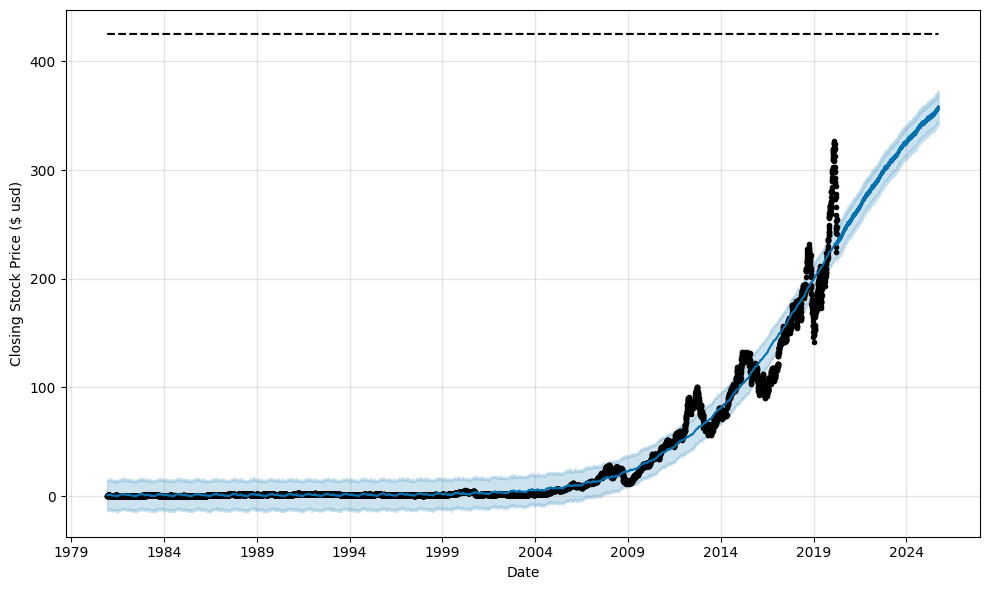

In [50]:
future = prophet_model.make_future_dataframe(periods=2000)
future['cap'] = max(stock_APPL['Close']) * 1.3
forecast = prophet_model.predict(future)
fig = prophet_model.plot(forecast, xlabel='Date', ylabel='Closing Stock Price ($ usd)')